In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import os
import platform
from pathlib import Path
import sys
from tqdm import tqdm

FILE = Path('__file__').resolve()
ROOT = FILE.parents[0]  # UNDERWATER-IMAGE-ANALYSIS root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

from utils.segmentation import *
from utils.calibration import *
from utils.dataloaders import (IMG_FORMATS, VID_FORMATS, check_file, increment_path, select_device, check_imshow,  Profile, LoadImages, LoadScreenshots, LoadStreams)


/home/bra/anaconda3/envs/detectron_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def draw_text(img, text,
          font=cv2.FONT_HERSHEY_PLAIN,
          pos=(0, 0),
          font_scale=3,
          font_thickness=2,
          text_color=(0, 255, 0),
          text_color_bg=(0, 0, 0)
          ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y + text_h), text_color_bg, -1)
    cv2.putText(img, text, (x, int(y + text_h + font_scale - 1)), font, font_scale, text_color, font_thickness)

    return text_size


In [7]:

def dist_on_img(segment_points, boxes, im, distances, classes, class_dict, copy=True, show=True):
    # Creer une sauvegarde
    img = im.copy() if copy else im
    
    for i,box in enumerate(boxes):
        class_name = class_dict[str(classes[i].item())]
        cv2.drawContours(img, [np.int0(box)], -1, (0, 0, 255), 2)
        # mid = mid_point(box)
        highest = min(box, key=lambda point: point[1])
        draw_text(img=img, text=class_name, pos=(int(highest[0]) + 10, int(highest[1]) - 10), 
                  font_scale=2, font_thickness=2, text_color=(255, 255, 255), text_color_bg=(0, 0, 0))


    # Initialiser un tableau de tableau vide pour stocker les points de segmentation de chaque espece
    for j, segment_point in enumerate(segment_points):
        # dessiner les lines de longuer et de largeur
        for i, n in zip(range(0, len(segment_point), 2), range(len(distances[j]))):
            start = (int(segment_point[i][0]), int(segment_point[i][1]))
            end = (int(segment_point[i+1][0]), int(segment_point[i+1][1]))
            x = start[0] + (end[0] - start[0]) * 0.25
            y = start[1] + (end[1] - start[1]) * 0.25
            # Dessiner le segment sur l'image
            cv2.line(img, start, end, (255, 0, 0), 2)
            draw_text(img=img, text="{:.1f} cm".format(distances[j][n]), pos=(int(x) + 10, int(y) - 10), 
                  font_scale=2, font_thickness=2, text_color=(255, 255, 255), text_color_bg=(0, 0, 0))
    if show == True:
        #Afficher l'image
        cv2.imshow("Points segmentation", img)
        cv2.waitKey(0)
    return img


(-0.5, 450.5, 299.5, -0.5)

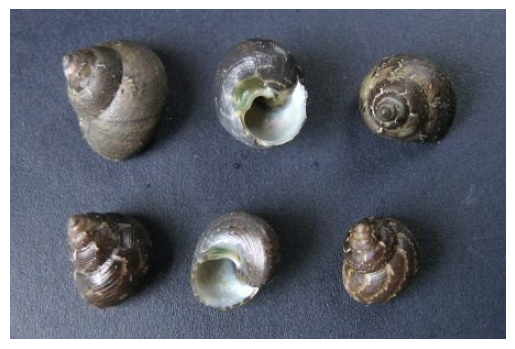

In [12]:
image = cv2.imread(r'/home/bra/Downloads/test.jpg')
plt.imshow(image[:, :, ::-1], cmap='gray'); plt.axis(False)

In [22]:
visualize = False
mtx1, mtx2, R, T = load_calibration("stereo_calibration/camera_parameters/stereo_params.pkl")
# Calculate the projection martrix
P1, P2 = get_projection_matrix(mtx1, mtx2, R, T)
predictor, cfg = init_config(str(ROOT / 'models/model_final.pth'), SCORE_THRESH_TEST = 0.8)

# Inferred with the images of each camera
output1 = inference(predictor, cfg,  image, show=visualize)
output2 = inference(predictor, cfg,  image, show=visualize)

# voir les classes predites
## le resultat est de la forme : tensor([0, 1, 1, 2, 3, 3]), cela veut dire :
## une espces PFE, deux actinia fermées, une ouverte et deux gibbula
classes1 = output1["instances"].pred_classes


# Get segmentation points " A optimiser "
uvs1, seg1, boxes1 = get_segment_points(output1)
uvs2, seg2, boxes2 = get_segment_points(output2)

        
# transforme the 2D points in the images to 3D points in the exit()world
p3ds = transforme_to_3D(P1, P2, uvs1, uvs2)

if visualize:
    # visualize the 3D points
    show_scatter_3D(p3ds)

class_dict = {
                "0" : "PFE",
                "1" : "Actinia fermee",
                "2" : "Actinia ouverte",
                "3" : "Gibbula"
            }


distances, connections = get_3D_distances(p3ds, connections = [[0,2], [1,3]])

im1_seg = dist_on_img(uvs1, boxes1, image, distances, classes1, class_dict, copy=False, show=visualize)


/home/bra/anaconda3/envs/detectron_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/bra/Downloads/underwater-image-analysis/utils/segmentation.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coords = np.array(coordonnes)


(-0.5, 450.5, 299.5, -0.5)

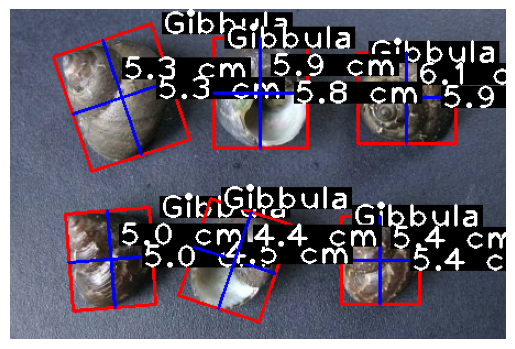

In [24]:
plt.imshow(im1_seg[:, :, ::-1]); plt.axis(False)

In [282]:
import cv2
import numpy as np
from skimage.draw import line

# Charger une image
img = cv2.imread('data/imgs_c2/image1283_jpg.rf.8419e876537c6b747f144d12f209b010.jpg')
print(img.shape)
w, h = img.shape[:2]
#Dessiner une ligne
x1, y1, x2, y2 = w//2, 0, w//2, h
x3, y3, x4, y4 = 0, h//2, w, h//2

(640, 640, 3)


In [285]:
def extract_desired_color_coordinates(img, color):
    # Créer un masque pour isoler les pindices_2ixels de la couleur cible
    mask = np.all(img == color, axis=-1)
    # Trouver les coordonnées des pixels de la couleur cible
    x, y = np.where(mask)
    
    return np.column_stack((x, y))

In [286]:
cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
l1 = extract_desired_color_coordinates(img, (255, 0, 0))
cv2.line(img, (x3, y3), (x4, y4), (0, 255, 0), 1)
l2 = extract_desired_color_coordinates(img, (0, 255, 0))
cv2.circle(img, (w//2, h//2), 200, (0, 0, 255), 1)
c = extract_desired_color_coordinates(img, (0, 0, 255)) 
l1

array([[  0, 320],
       [  1, 320],
       [  2, 320],
       ...,
       [637, 320],
       [638, 320],
       [639, 320]])

In [258]:
c

array([[120, 320],
       [121, 301],
       [121, 302],
       ...,
       [519, 338],
       [519, 339],
       [520, 320]])

(-0.5, 639.5, 639.5, -0.5)

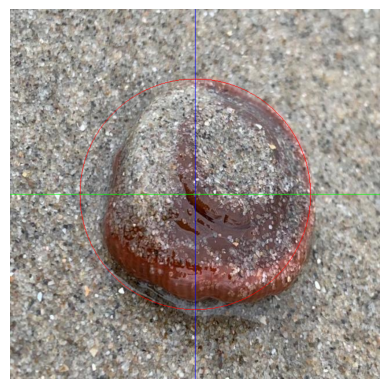

In [259]:
plt.imshow(img[:, :, ::-1])
plt.axis(False)

In [287]:
l2.shape, l1.shape, c.shape

((640, 2), (640, 2), (1128, 2))

In [289]:
indice = l1[(l1[:, None] == c).all(-1).any(1)]
(a,b),(c,d) = indice

In [272]:
l1[:, None] == l2

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [262]:
x = l1[np.all([np.isin(ai, c) for ai in  l1], axis=1)]
x

array([[120, 320],
       [121, 320],
       [122, 320],
       [123, 320],
       [124, 320],
       [125, 320],
       [126, 320],
       [127, 320],
       [128, 320],
       [129, 320],
       [130, 320],
       [131, 320],
       [132, 320],
       [133, 320],
       [134, 320],
       [135, 320],
       [136, 320],
       [137, 320],
       [138, 320],
       [139, 320],
       [140, 320],
       [141, 320],
       [142, 320],
       [143, 320],
       [144, 320],
       [145, 320],
       [146, 320],
       [147, 320],
       [148, 320],
       [149, 320],
       [150, 320],
       [151, 320],
       [152, 320],
       [153, 320],
       [154, 320],
       [155, 320],
       [156, 320],
       [157, 320],
       [158, 320],
       [159, 320],
       [160, 320],
       [161, 320],
       [162, 320],
       [163, 320],
       [164, 320],
       [165, 320],
       [166, 320],
       [167, 320],
       [168, 320],
       [169, 320],
       [170, 320],
       [171, 320],
       [172,

In [186]:
common_elements, indices_1, indices_2 = np.intersect1d(l1.view([('', l1.dtype)] * l1.shape[1]), c.view([('', c.dtype)] * c.shape[1]), return_indices = True)
common_elements, indices_1, indices_2

(array([(120, 320), (520, 320)], dtype=[('f0', '<i8'), ('f1', '<i8')]),
 array([120, 520]),
 array([   0, 1127]))

In [199]:
np.array([(120, 320), (520, 320)], dtype=[('f0', '<i8'), ('f1', '<i8')])

array([(120, 320), (520, 320)], dtype=[('f0', '<i8'), ('f1', '<i8')])

In [202]:
# Convertir les tuples en listes
tab1 = [list(i) for i in l1]
tab2 = [list(i) for i in c]

# Trouver les éléments en commun
common_elements = list(set(tab1) & set(tab2))
print(common_elements)

TypeError: unhashable type: 'list'

In [196]:
tab1.shape

(5,)

In [193]:
common_elements, indices_1, indices_2 = np.intersect1d(l2.view([('', l2.dtype)] * l2.shape[1]), c.view([('', c.dtype)] * c.shape[1]), return_indices = True)
common_elements

array([(320, 120), (320, 520)], dtype=[('f0', '<i8'), ('f1', '<i8')])

In [170]:
cv2.line(img, common_elements[0], common_elements[1], (0, 255, 0), 1)

array([[[128, 130, 130],
        [126, 128, 128],
        [134, 136, 136],
        ...,
        [181, 186, 187],
        [175, 180, 181],
        [171, 176, 177]],

       [[120, 122, 122],
        [131, 133, 133],
        [151, 153, 153],
        ...,
        [181, 186, 187],
        [174, 179, 180],
        [170, 175, 176]],

       [[126, 128, 128],
        [146, 148, 148],
        [172, 174, 174],
        ...,
        [181, 186, 187],
        [172, 180, 180],
        [168, 176, 176]],

       ...,

       [[125, 131, 138],
        [140, 146, 153],
        [157, 165, 172],
        ...,
        [174, 182, 182],
        [179, 184, 185],
        [168, 173, 174]],

       [[122, 128, 135],
        [139, 145, 152],
        [161, 169, 176],
        ...,
        [141, 149, 149],
        [160, 165, 166],
        [178, 183, 184]],

       [[118, 124, 131],
        [137, 143, 150],
        [162, 170, 177],
        ...,
        [108, 116, 116],
        [122, 127, 128],
        [158, 163, 164]]

(-0.5, 639.5, 639.5, -0.5)

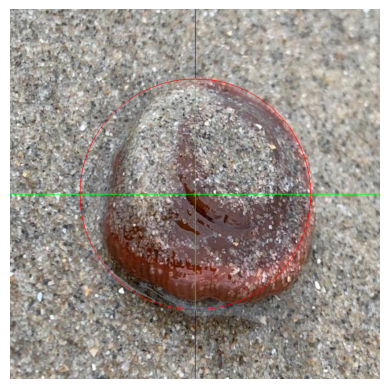

In [171]:
plt.imshow(img[:, :, ::-1])
plt.axis(False)

In [52]:

# being start and end two points (x1,y1), (x2,y2)
discrete_line1 = list(zip(*line(*(x1,y1), *(x2,y2))))
discrete_line2 = list(zip(*line(*(x3,y3), *(x4,y4))))

In [ ]:
def extract_desired_color_coordinates(img, color):
    # Créer un masque pour isoler les pixels de la couleur cible
    mask = np.all(img == color, axis=-1)
    # Trouver les coordonnées des pixels de la couleur cible
    x, y = np.where(mask)
    return np.column_stack((x, y))

In [ ]:
def extract_caractristics(mask, pts):
    (x1, y1), (x2, y2), (x3, y3), (x4, y4) = pts
    
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
    l1 = extract_desired_color_coordinates(img, (255, 0, 0))
    cv2.line(img, (x3, y3), (x4, y4), (0, 255, 0), 1)
    l2 = extract_desired_color_coordinates(img, (0, 255, 0))
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    assert len(contours) == 1, f'we are supposed to retrieve a single contour that represents a species in what we have {len(contours)} contours.'
    cv2.drawContours(img, [contours], 0, (0, 0, 255), 2)
    c = extract_desired_color_coordinates(img, (0, 0, 255))
    common_elements1 = l1[(l1[:, None] == c).all(-1).any(1)]
    common_elements2 = l2[(l2[:, None] == c).all(-1).any(1)]
    (x1, y1), (x2, y2) = common_elements1
    (x3, y3), (x4, y4) = common_elements2
    return [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]

# Nous affichon la segmentation de detectron mais nous ajouton seulement nos largeur longueur
# Je veux des exemple de de tes carrès

In [189]:
(x1, y1), (x2, y2), (x3, y3), (x4, y4) = [(100, 400), (2, 3), (50, 25), (55, 6)]
(x1, y1), (x2, y2), (x3, y3), (x4, y4)

((100, 400), (2, 3), (50, 25), (55, 6))

In [192]:
f = [(100., 400.), (2., 3.), (50., 25.), (55., 6.)]


TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [ ]:
cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
l1 = extract_desired_color_coordinates(img, (255, 0, 0))
cv2.line(img, (x3, y3), (x4, y4), (0, 255, 0), 1)
l2 = extract_desired_color_coordinates(img, (0, 255, 0))
cv2.circle(img, (w//2, h//2), 200, (0, 0, 255), 1)
c = extract_desired_color_coordinates(img, (0, 0, 255))

In [ ]:
common_elements, indices_1, indices_2 = np.intersect1d(l1.view([('', l1.dtype)] * l1.shape[1]), c.view([('', c.dtype)] * c.shape[1]), return_indices = True)
common_elements, indices_1, indices_2

In [181]:
common_elements[0], common_elements[1]

((120, 320), (520, 320))

In [232]:
a = np.array([[262.5, 262.5, 45],
              [262.5, 262.5, 15],
              [262.5, 187.5, 45],
              [262.5, 187.5, 15],
              [187.5, 262.5, 45],
              [187.5, 262.5, 15],
              [187.5, 187.5, 45],
              [187.5, 187.5, 15]])

b = np.array([[262.5, 262.5, 45],
              [262.5, 262.5, 15],
              [3,3,5],
              [5,5,7],
              [8,8,9]])

In [233]:
a[np.all([np.isin(ai, b) for ai in  a], axis=1)]


array([[262.5, 262.5,  45. ],
       [262.5, 262.5,  15. ]])